In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import seaborn as sns
import cmocean
import cmasher as cmr
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = "Serif"

In [2]:
def scale_factor_spectrum(z,data,error,wo_wave):
    k = 1+z
    select1 = (wo_wave>5030*k) & (wo_wave<5050*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact


In [3]:
def popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2=False):
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave<5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 0
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(full_gauss,x0=p_init,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    (amp_Hb_error,amp_OIII5007_error,vel_OIII_error,vel_sigma_OIII_error,amp_Hb_br_error,amp_OIII5007_br_error,vel_OIII_br_error,vel_sigma_OIII_br_error,amp_Hb1_error,amp_Fe5018_1_error,vel_Hb1_error,vel_sigma_Hb1_error,amp_Hb2_error,amp_Fe5018_2_error,vel_Hb2_error,vel_sigma_Hb2_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 

In [4]:
def red_data_err(data,model,res,x0,y0,x_m,y_m,muse_sampling_size,box_size=3):
    if muse_sampling_size == 0.4:
        (y_cen,x_cen)=(int(round(y_m)),int(round(x_m)))
        data_red = data[y_cen-box_size:y_cen+box_size+1,x_cen-box_size:x_cen+box_size+1]
        mod_red = model[y_cen-box_size:y_cen+box_size+1,x_cen-box_size:x_cen+box_size+1]
        residual_red = res[y_cen-box_size:y_cen+box_size+1,x_cen-box_size:x_cen+box_size+1]
        (x0,y0)=(x0-7,y0-7)
    else:
        (y_cen,x_cen)=(int(round(y_m)),int(round(x_m)))
        data_red = data[y_cen-2*box_size-1:y_cen+2*box_size+2,x_cen-2*box_size-1:x_cen+2*box_size+2]
        mod_red =model[y_cen-2*box_size-1:y_cen+2*box_size+2,x_cen-2*box_size-1:x_cen+2*box_size+2]
        residual_red =res[y_cen-2*box_size-1:y_cen+2*box_size+2,x_cen-2*box_size-1:x_cen+2*box_size+2]
        (x0,y0)=(x0-14,y0-14)
    #plt.imshow(data_red,origin='lower')
    #plt.show()
    err_red = (data_red - mod_red)/residual_red
    return data_red,mod_red,residual_red,err_red,x0,y0 

In [25]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,broad2=False,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE/Aperture Spectrum"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = popt_full_fit
    if amp_Hb_br_fit <0:
        amp_Hb_br_fit = 0
    else:
        amp_Hb_br_fit = amp_Hb_br_fit
    k = 1+z
    new_k = 1+ (vel_OIII_fit/300000)
    select = (wo_wave>4750*new_k) & (wo_wave < 5090*new_k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit

    #plt.style.use('ggplot')
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['axes.edgecolor'] = 'k'
    fig = plt.figure(figsize=(15, 10)) 
    gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1]) 
    
    #ax1 = plt.subplot(gs[0])
    #ax2 = plt.subplot(gs[1])
    ax1 = fig.add_axes([0.1, 0.29, 0.84, 0.7]) # main axes
    ax2 = fig.add_axes([0.1, 0.08, 0.84, 0.2]) # inset axes

    plt.setp(ax1.get_xticklabels(), visible=False)
    #ax1.xaxis.set_ticks_position('bottom') 
    #ax1.xaxis.set_label_position('bottom') 
    ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
    ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax1.minorticks_on()
    ax1.plot(wo_wave[select]/new_k,data[select],'r-',label='Spectrum',drawstyle='steps-mid',linewidth=3,color='gray')
    ax1.plot(wo_wave[select]/new_k,fit,'r',linestyle='dashed',label='Fit')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),color='green',linestyle='--',label='Narrow core')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='Broad wing',linestyle='-.')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_blr_gauss(wo_wave[select],amp_Hb1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':',label='BLR')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_blr_gauss(wo_wave[select],amp_Hb2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe4923_gauss(wo_wave[select],amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe4923_gauss(wo_wave[select],amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe5018_gauss(wo_wave[select],amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe5018_gauss(wo_wave[select],amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.set_xlim(4760,5090)
    ax1.set_ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
    ax1.text(4890,0.95*np.max(data),"%s"%(obj),fontsize=21)
    ax1.legend(facecolor='white', framealpha=1, fontsize=17, loc='upper left',borderpad=1)

    ax2.plot(wo_wave[select]/new_k,residual/error[select],drawstyle='steps-mid',color='black')
    ax2.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
    ax2.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax2.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax2.minorticks_on()
    ax2.axhline(y=0.0, color='maroon', linestyle='--')   
    ax2.axhspan(-3, 3, alpha=0.2, color='brown')
    ax2.set_xlim(4760,5090)
    ax2.set_ylim(-8,8)    
    ax2.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)
    ax2.set_ylabel(r"Residual/Error",fontsize=21)
    ax2.legend(fontsize=17)
   
    plt.tight_layout(pad=0.001, h_pad=0.001, w_pad=None)
    fig.savefig('%s/%s_aperture_spectra.png'%(destination_path_cube,obj),overwrite=True)
    

In [26]:
def algorithm_script(obj,z,broad2,prefix_path_cube="/home/rickeythecat/ftp.hidrive.strato.com/users/login-carsftp/IFU_data",destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    print ('%s'%(obj))
    (mini_cube,mini_err,mini_wave,mini_header) = loadCube('%s/%s/%s.3_arcsec_minicube.fits'%(destination_path_cube,obj,obj))
    (int_spectrum,int_err) = int_spec(mini_cube,mini_err)
    factor = scale_factor_spectrum(z,int_spectrum,int_err,mini_wave)
    int_err = factor*int_err
    popt_full_fit = full_specpar('%s/%s/%s_nonspectro_central_fit.fits'%(destination_path_cube,obj,obj))
    plot(obj,mini_wave,int_spectrum,int_err,z,popt_full_fit,broad2)

No handles with labels found to put in legend.


HE0021-1810


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0021-1819


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0040-1105


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0108-4743


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0114-0015


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0119-0118


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0212-0059


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0224-2834


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0227-0913


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0232-0900


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0253-1641


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0345+0056


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0351+0240


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0412-0803


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0429-0247


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0433-1028


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0853+0102


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE0934+0119


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE1011-0403


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
No handles with labels found to put in legend.


HE1017-0305


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


HE1029-1831


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


HE1107-0813


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


HE1108-2813


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


HE1126-0407


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


HE1237-0504


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


HE1248-1356


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


HE1330-1013


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


HE1353-1917


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


HE1417-0909


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


HE2128-0221


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


HE2211-3903


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


HE2222-0026


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


HE2233+0124


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
No handles with labels found to put in legend.


HE2302-0857


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


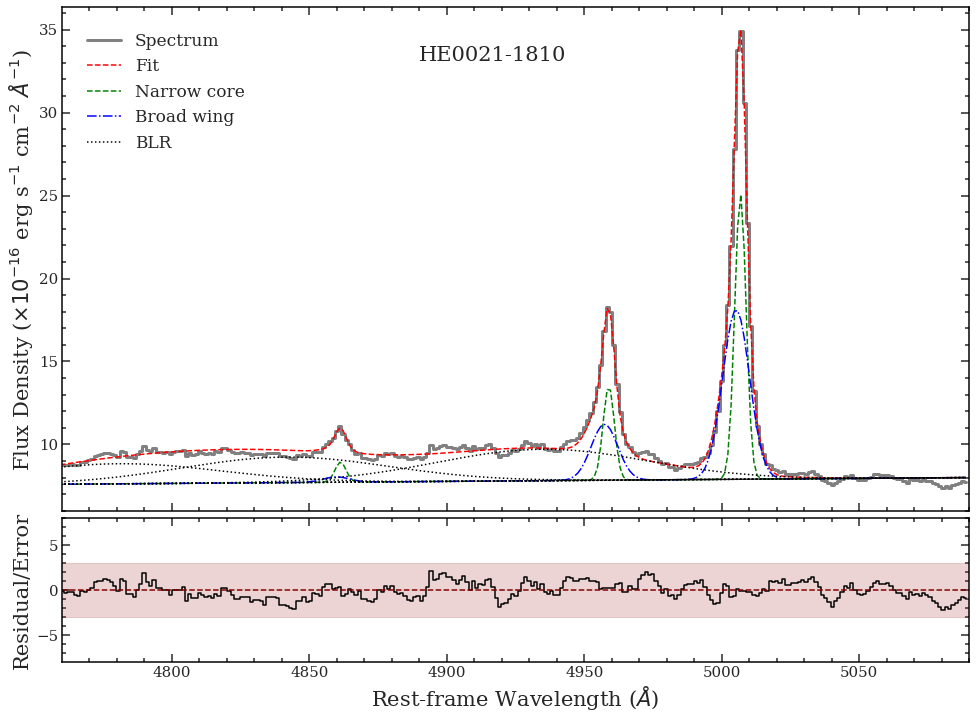

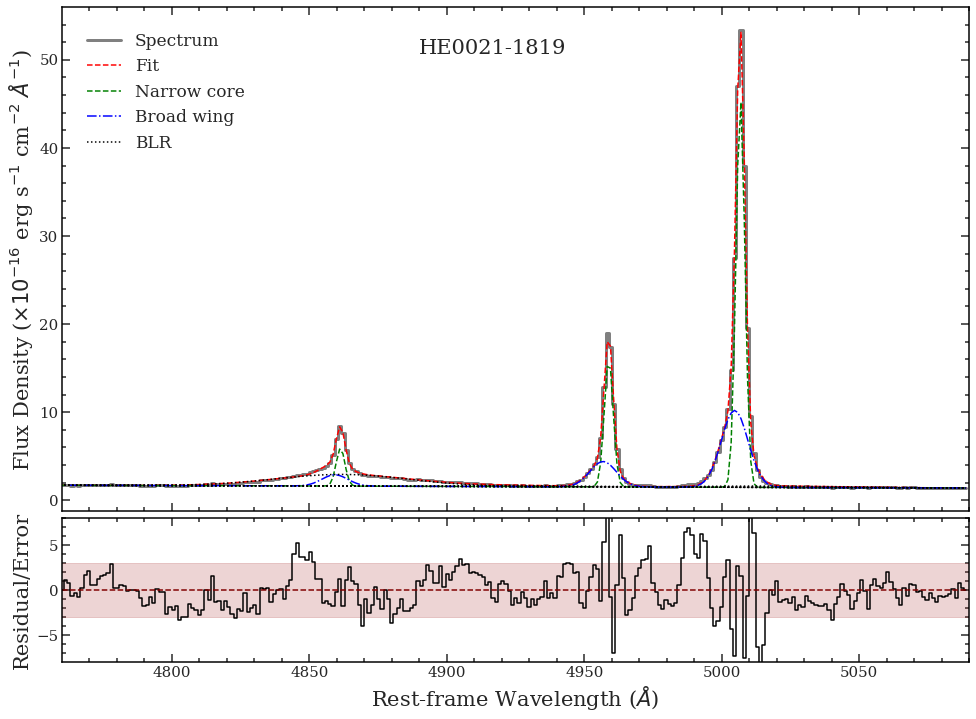

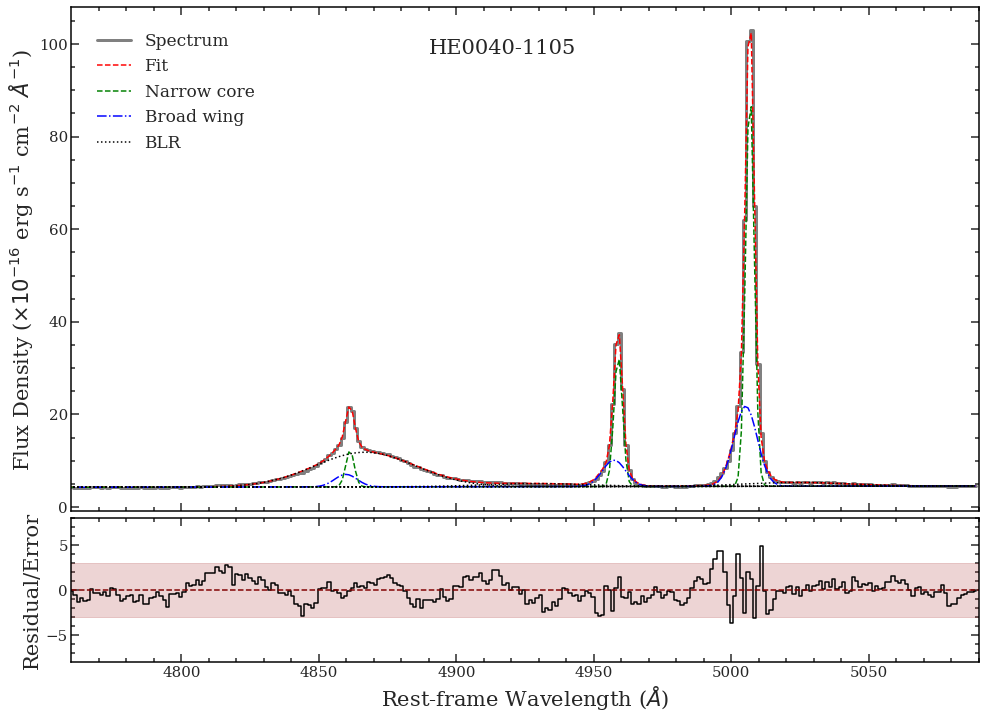

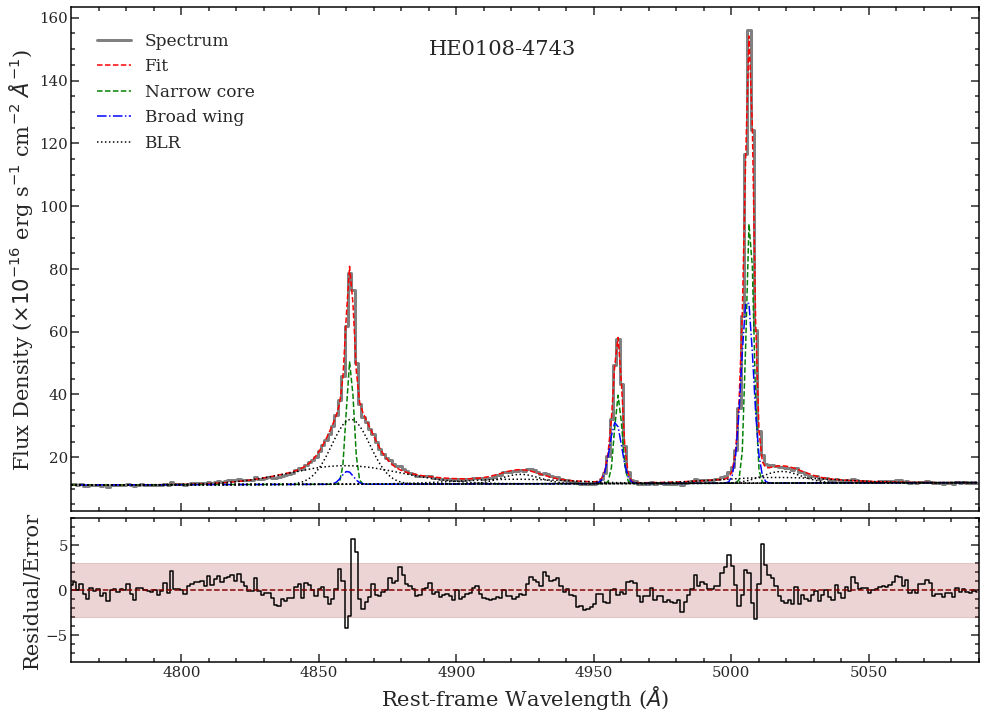

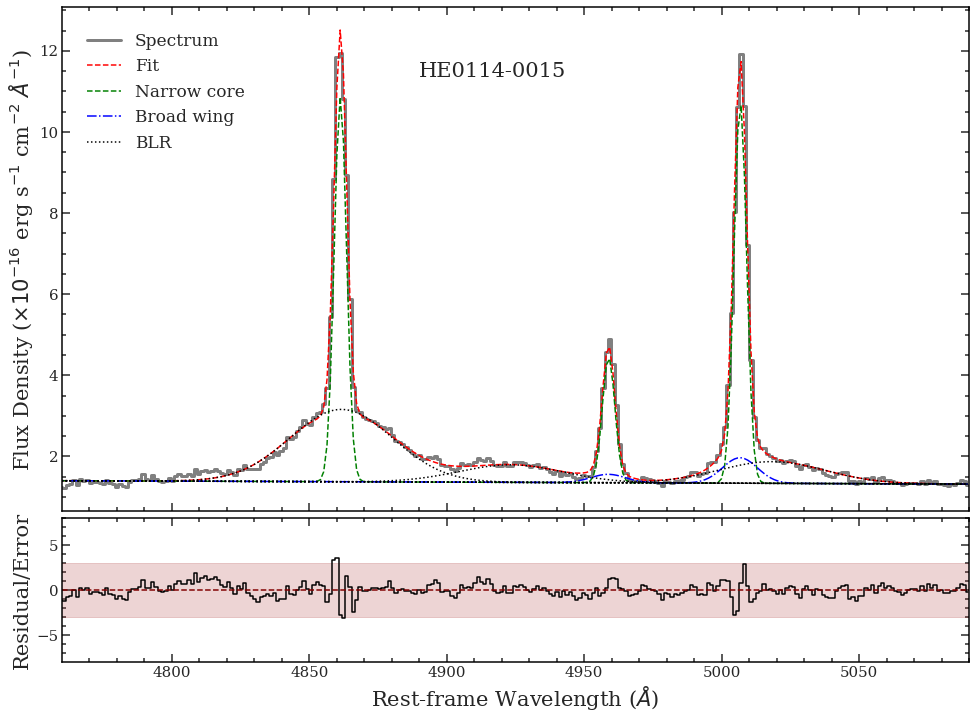

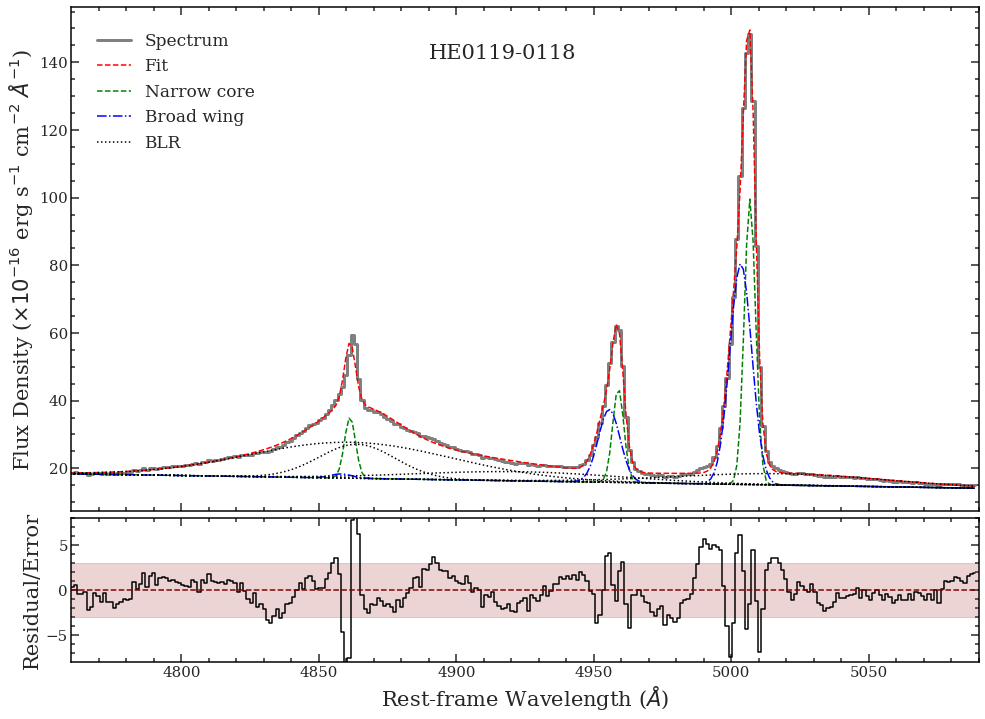

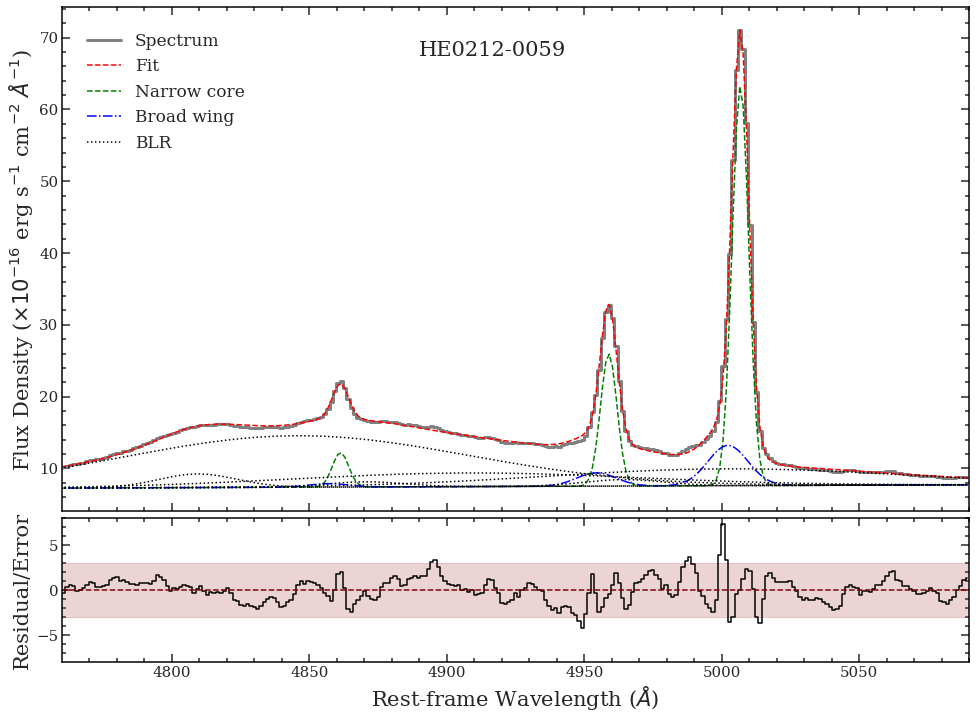

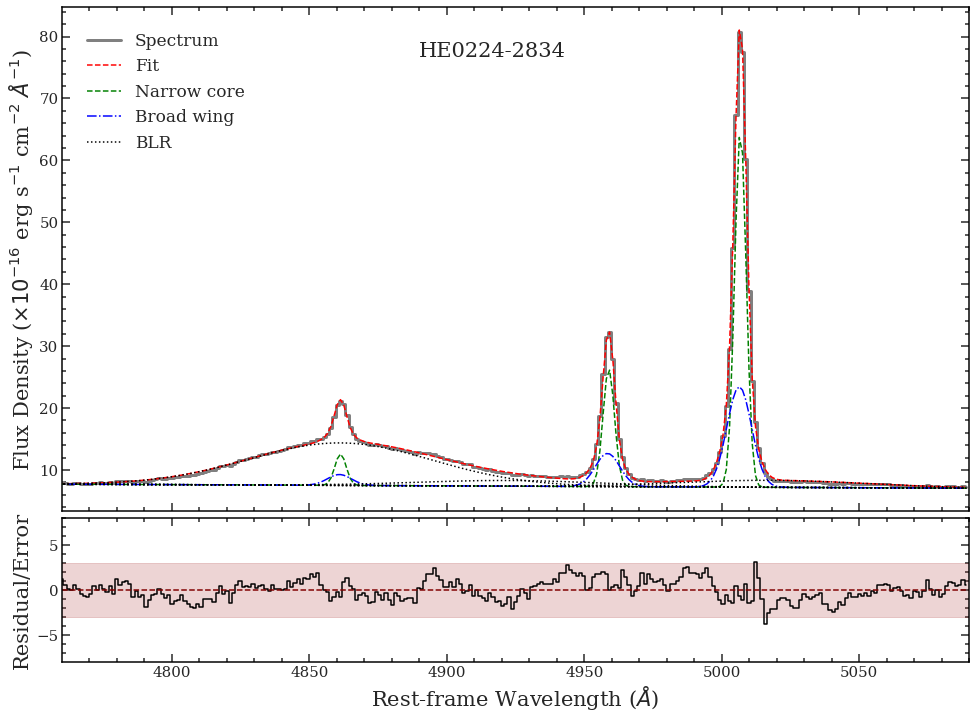

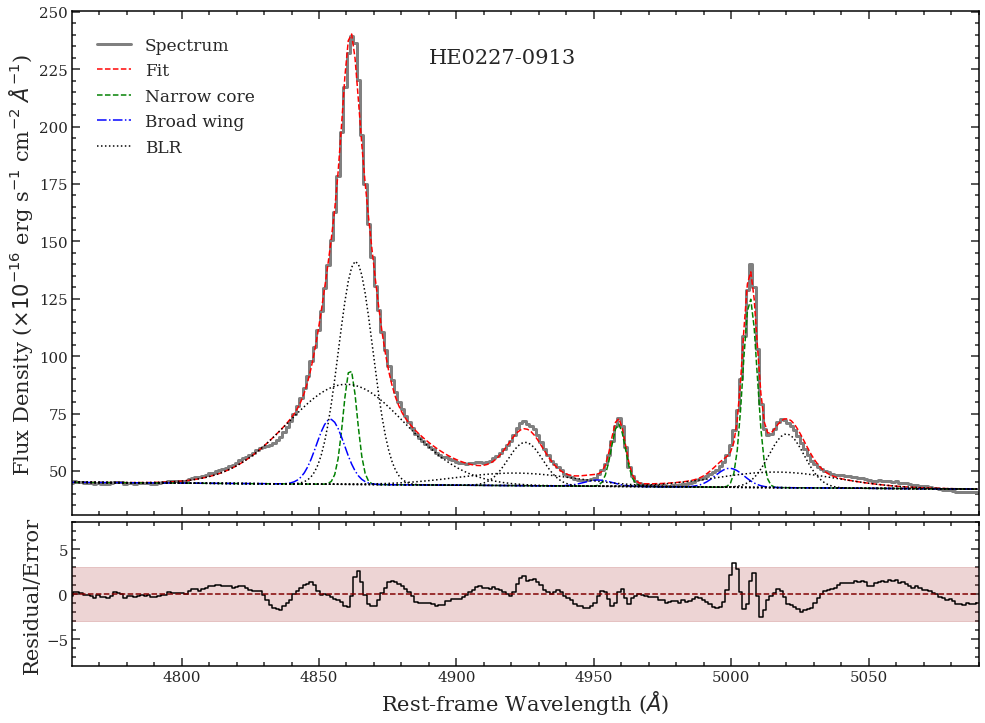

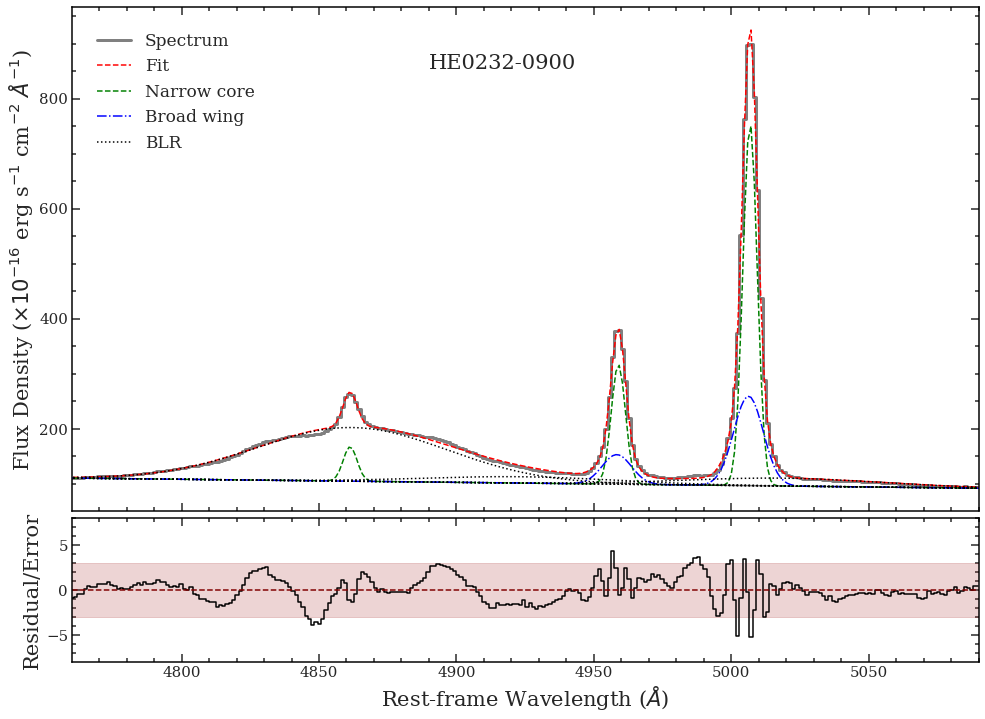

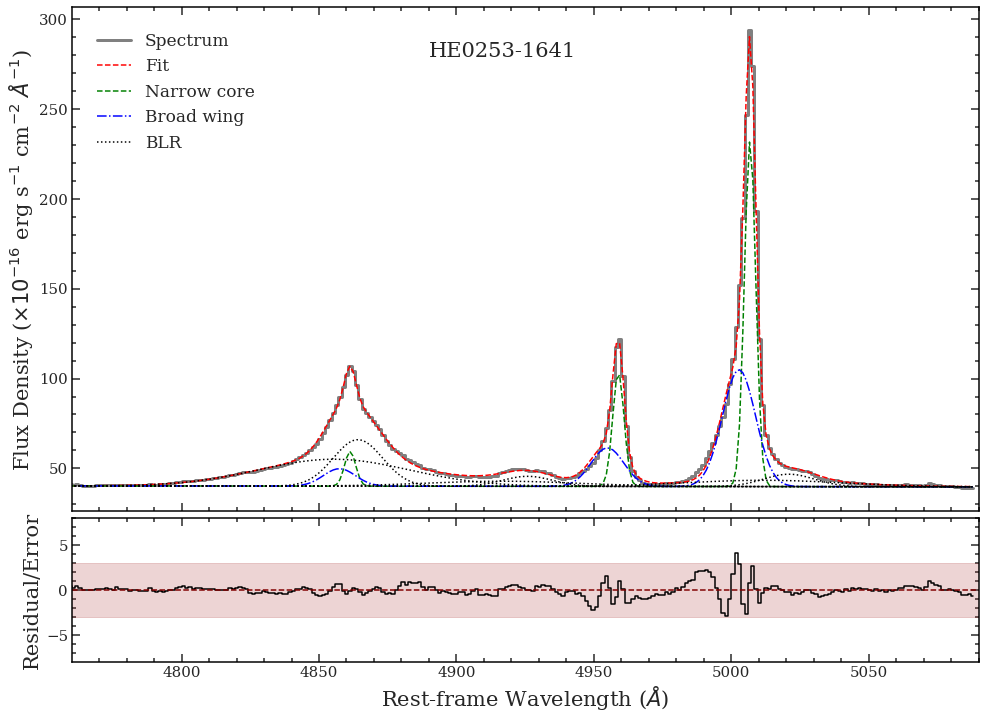

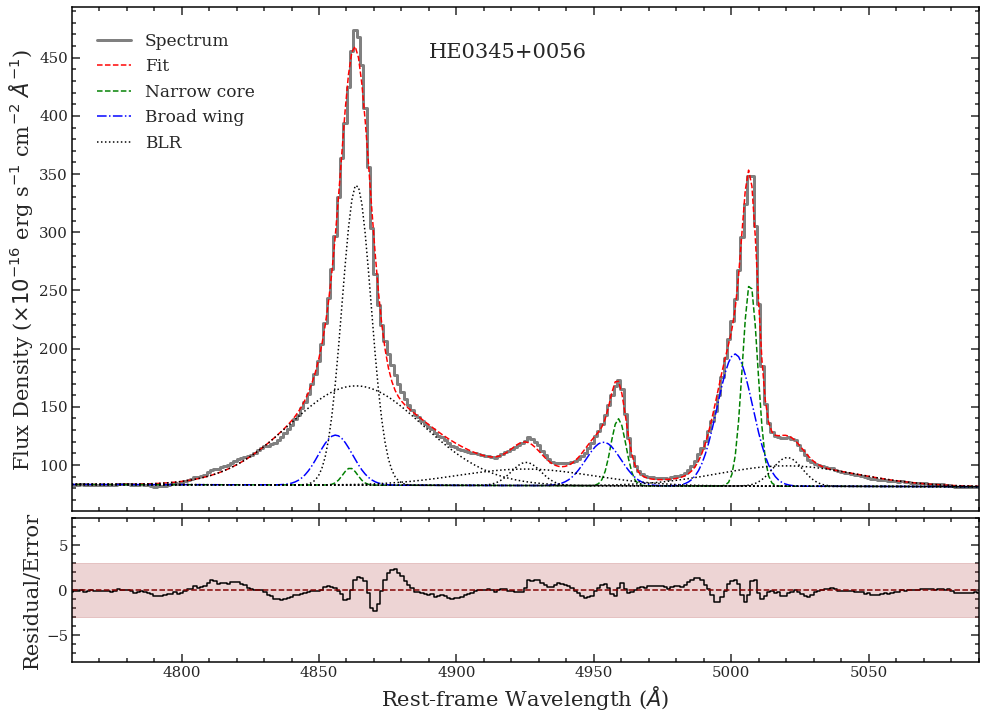

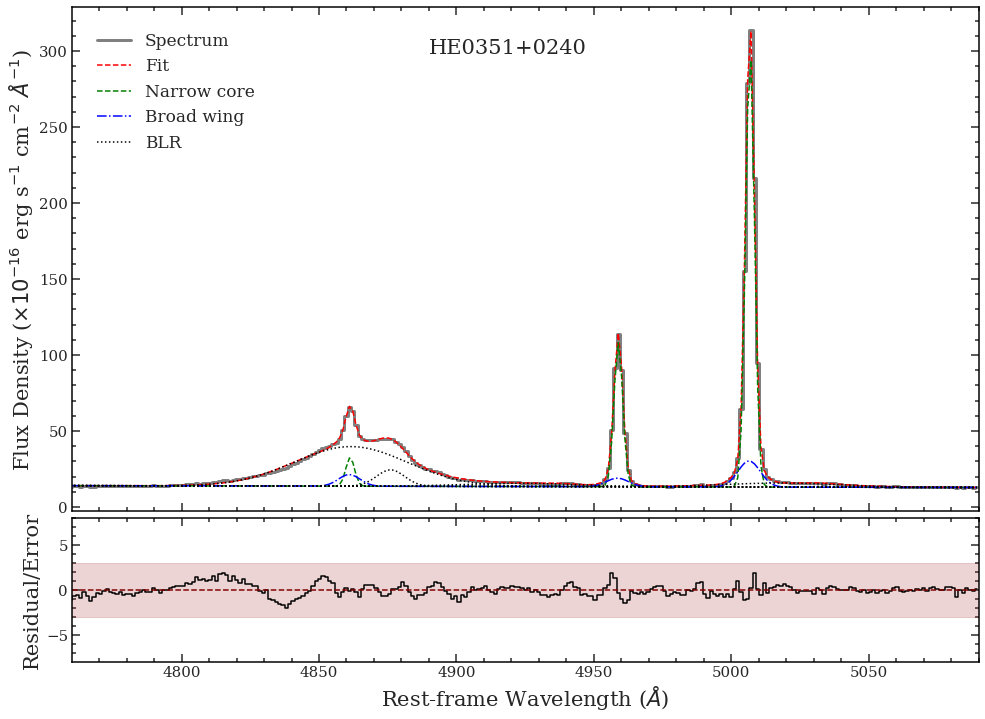

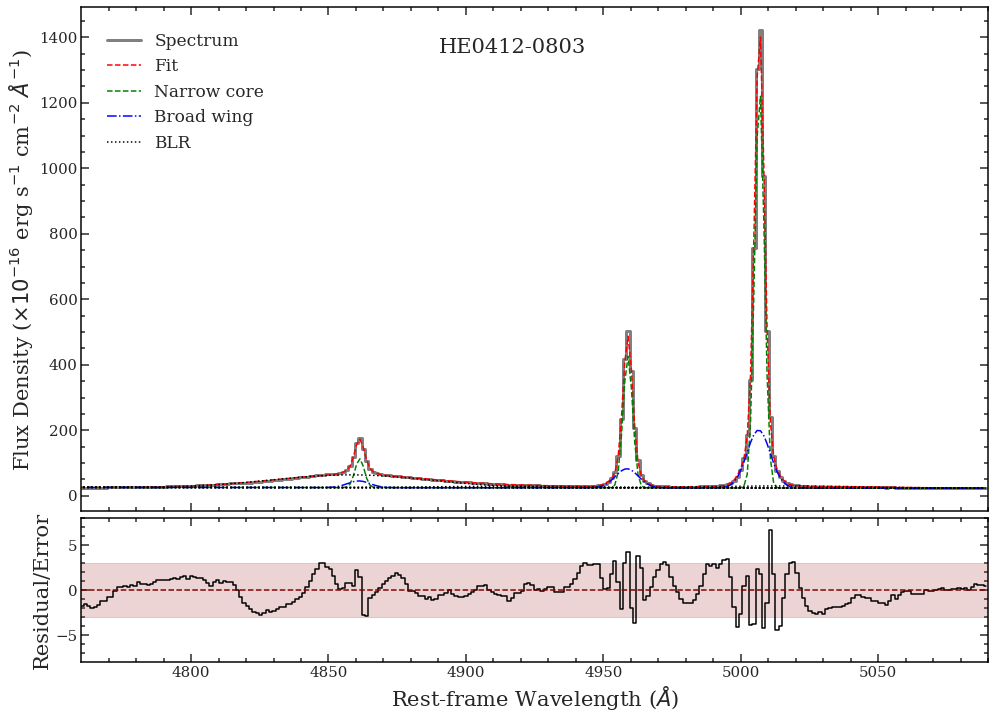

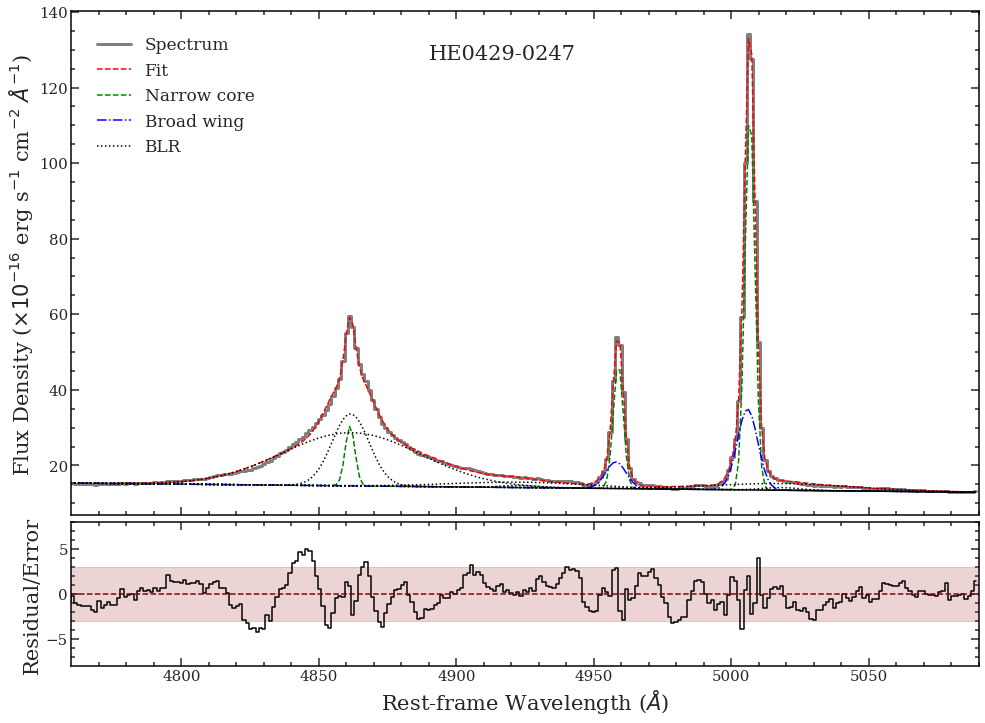

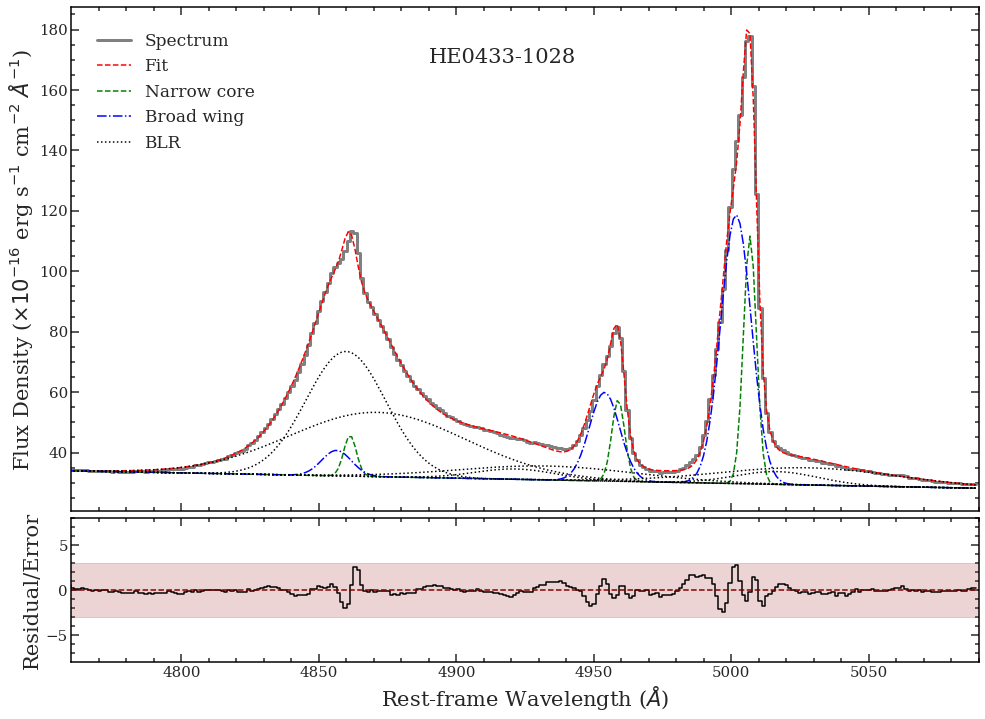

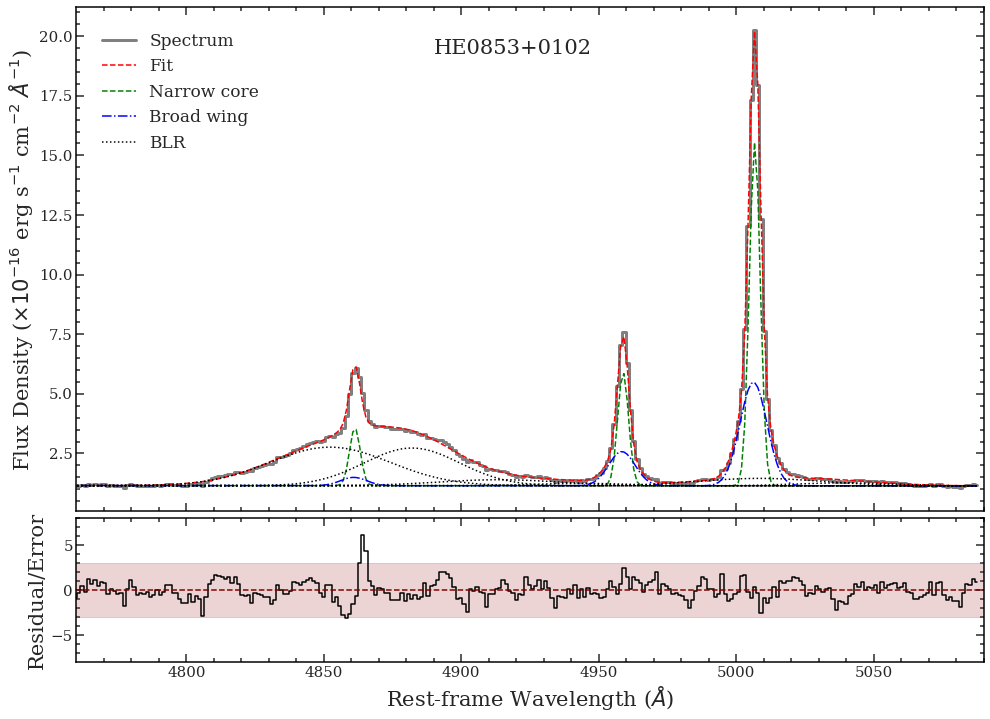

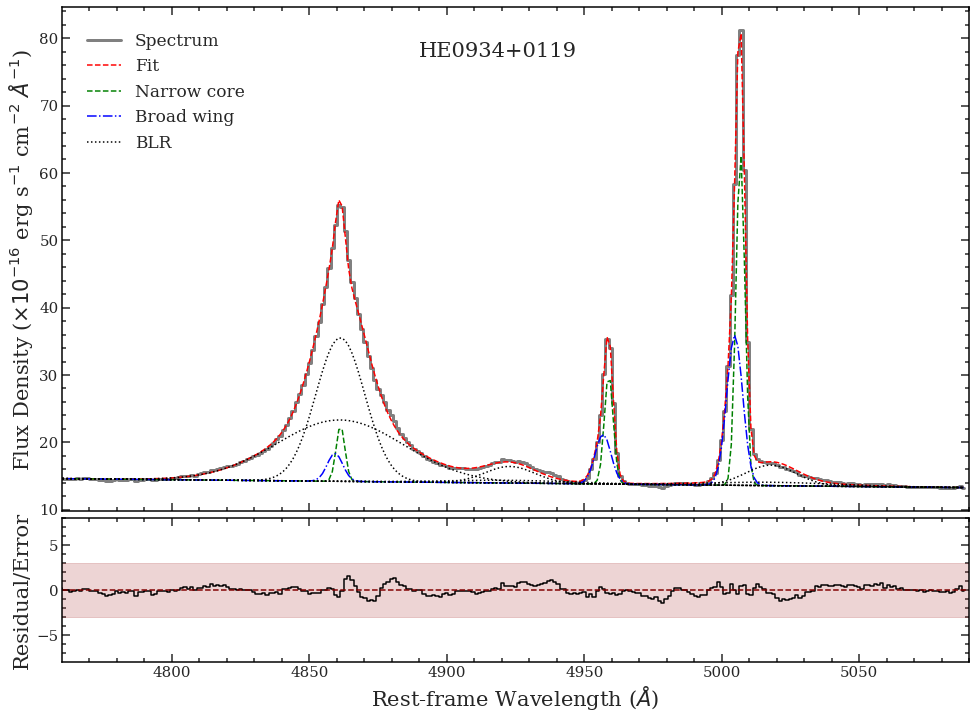

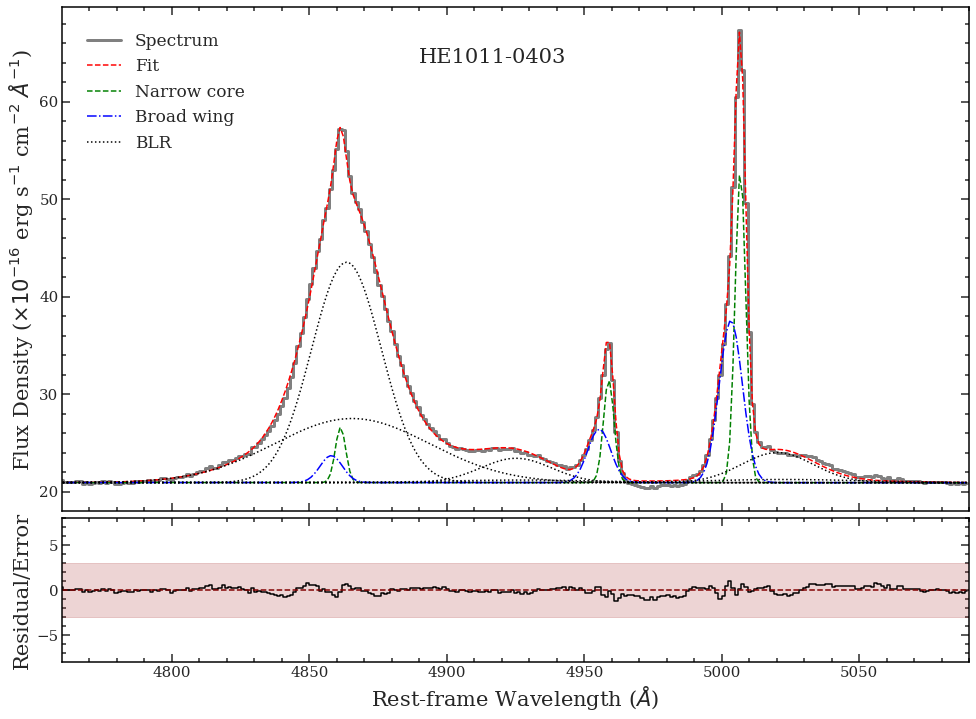

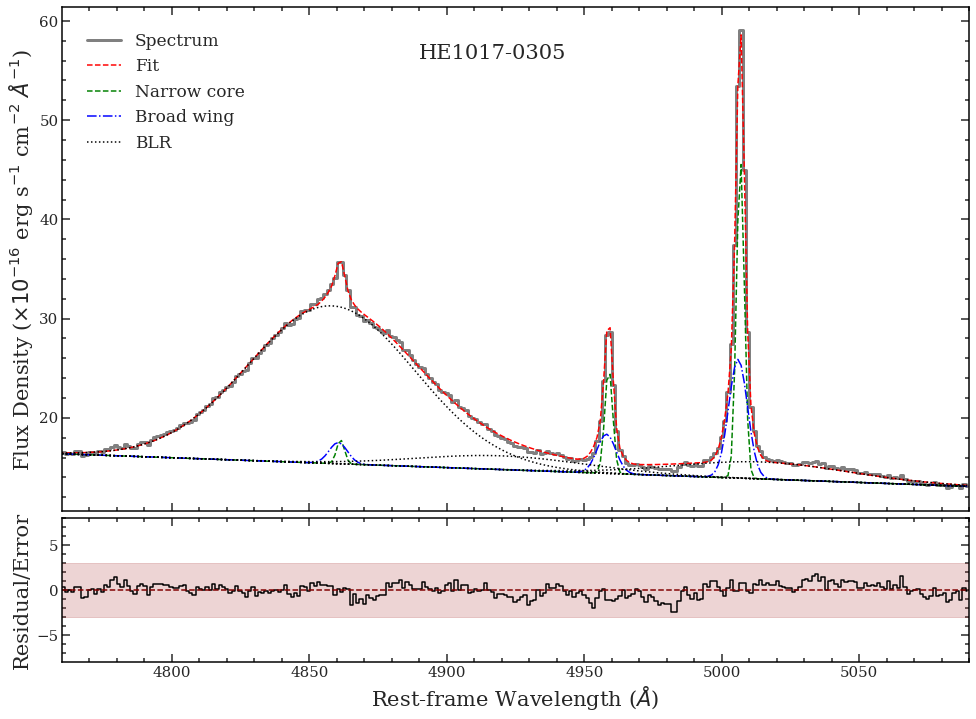

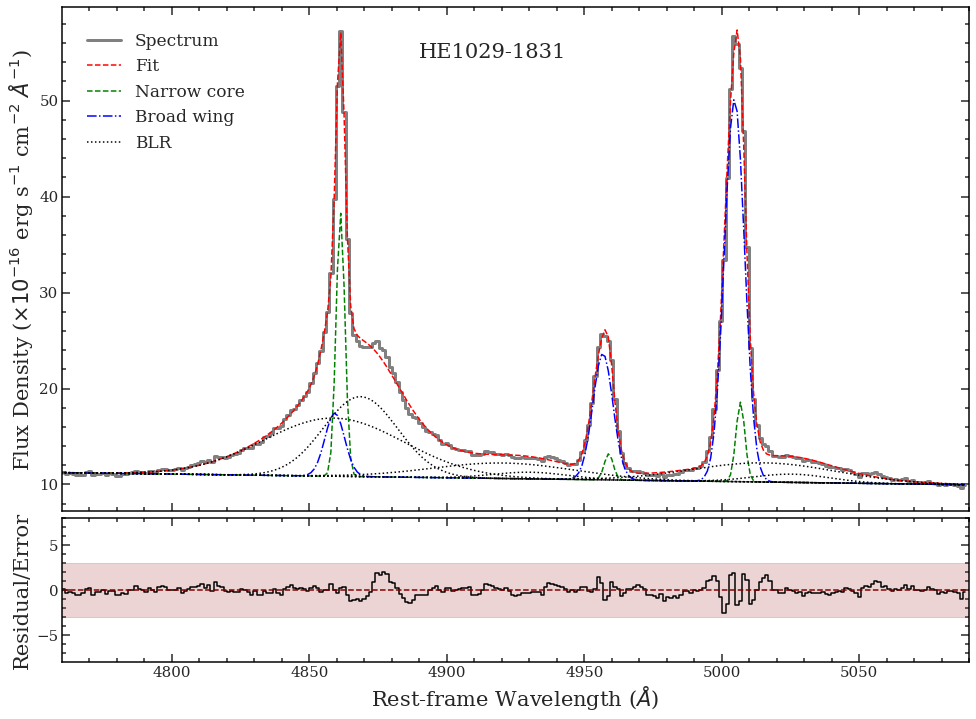

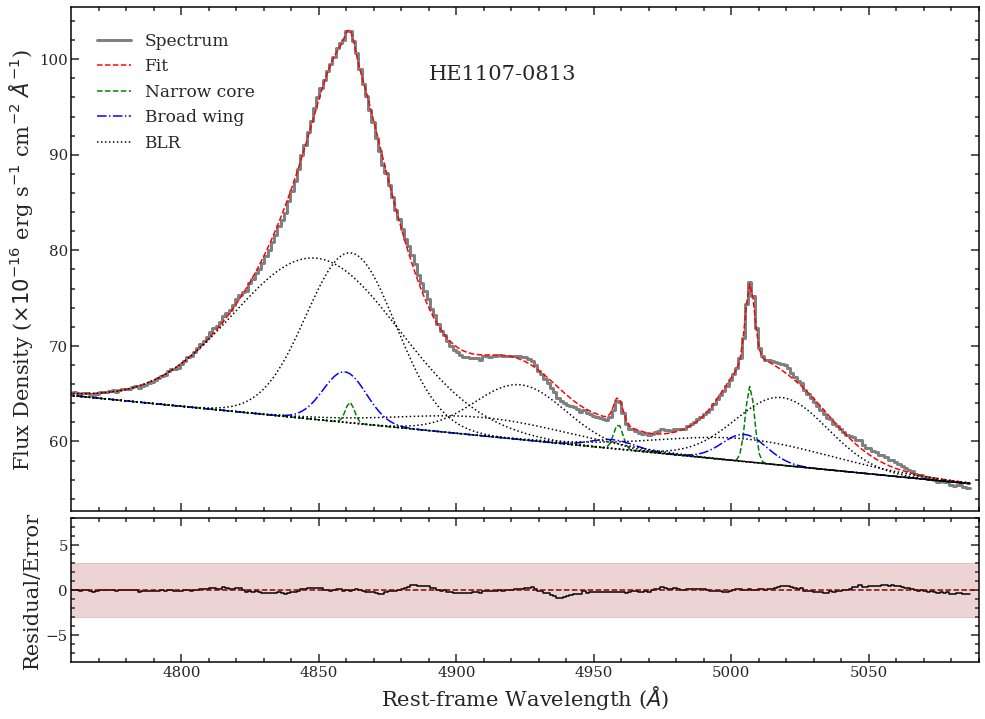

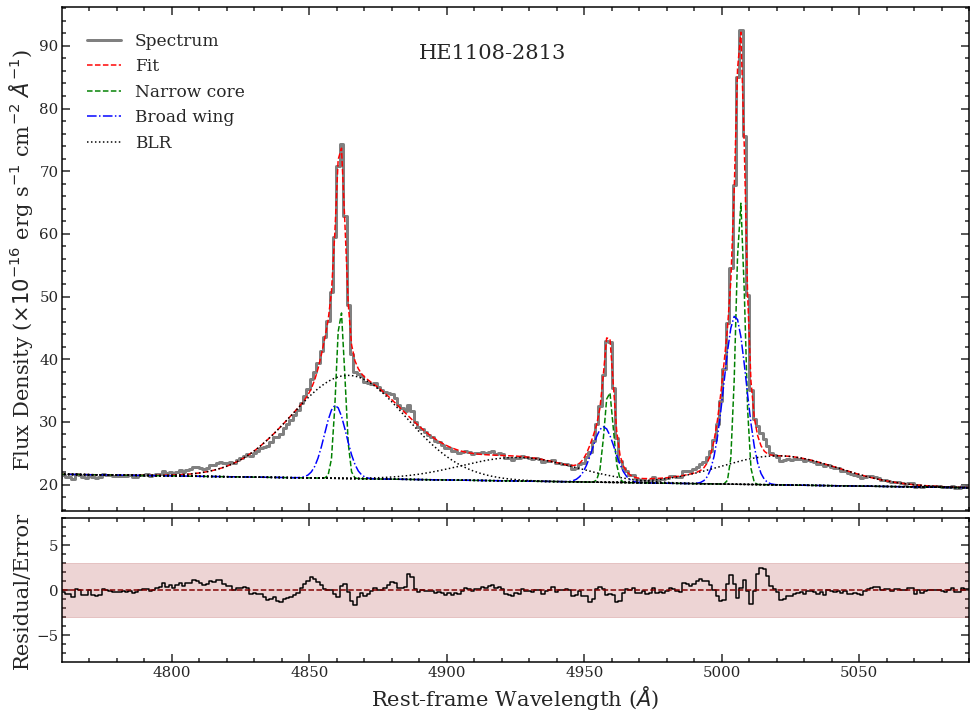

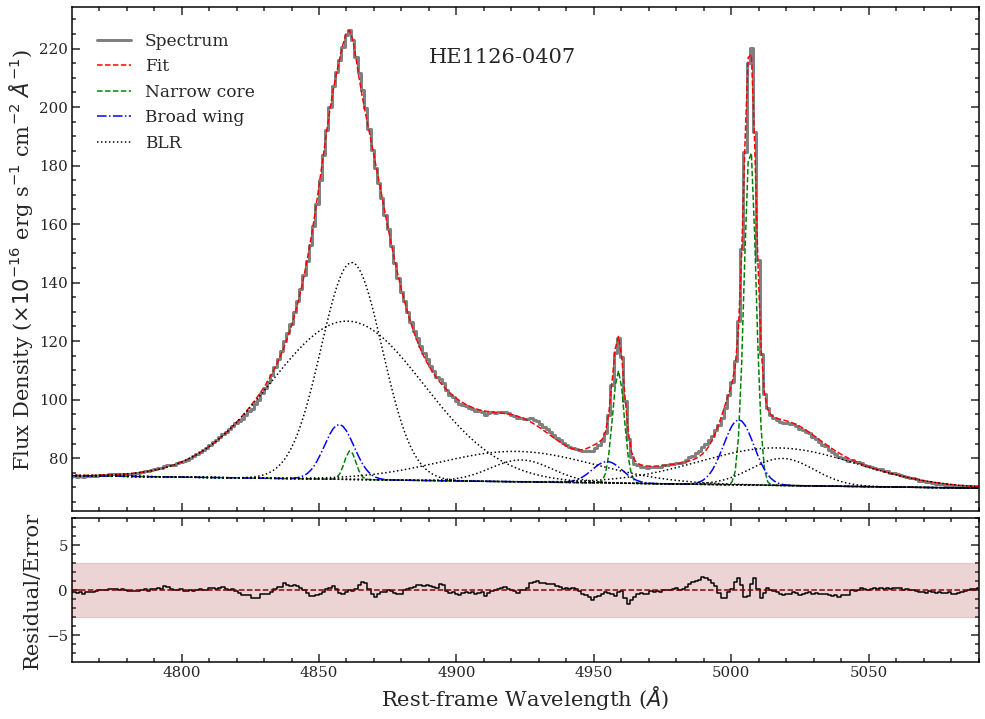

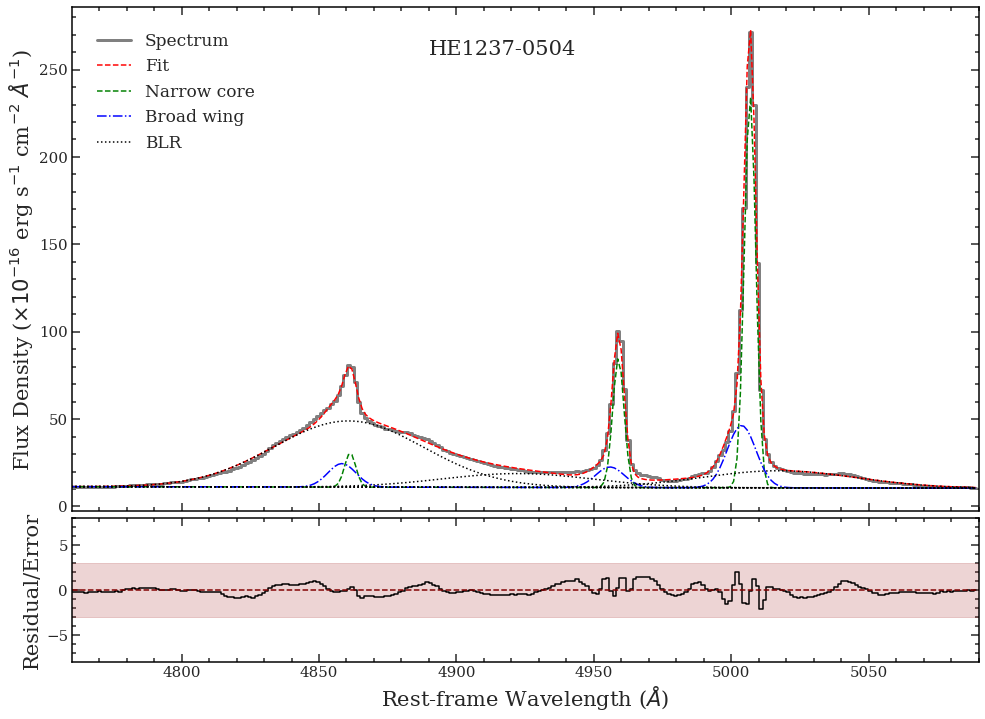

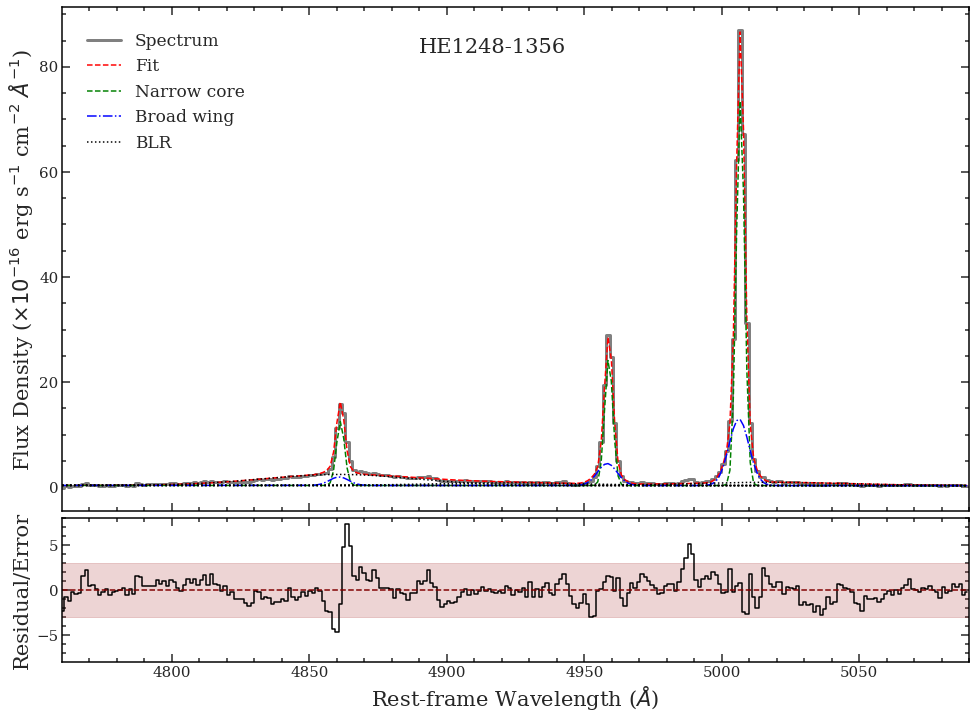

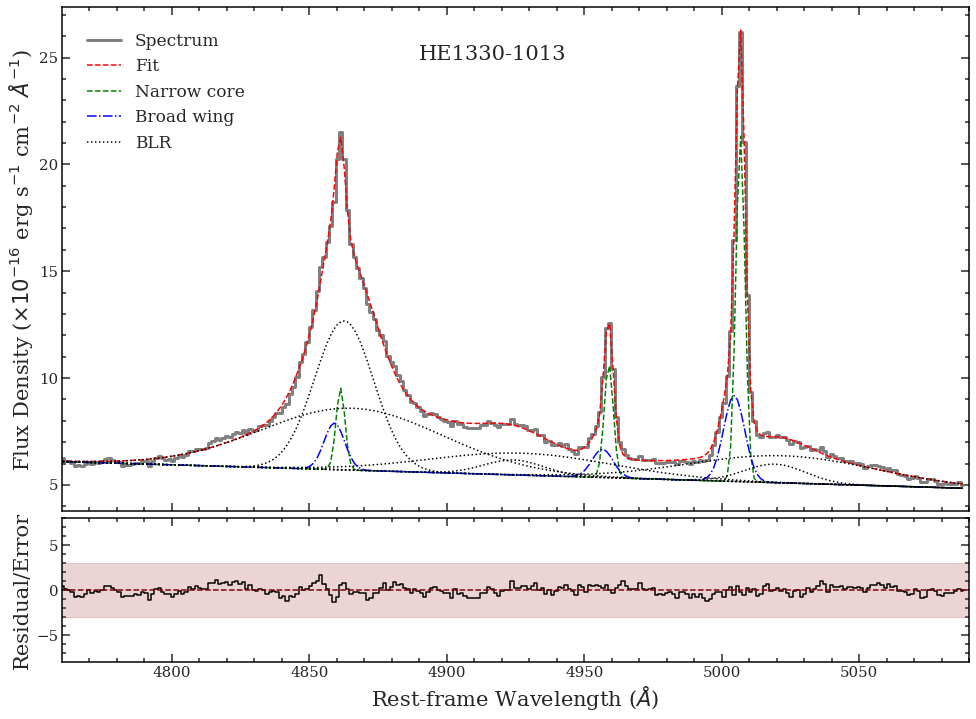

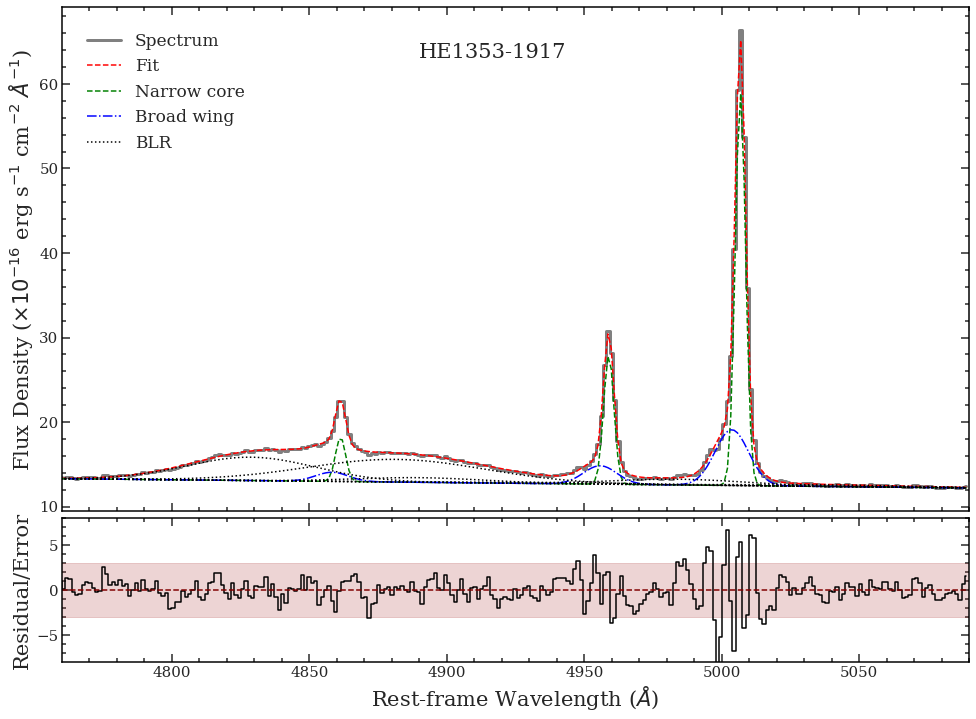

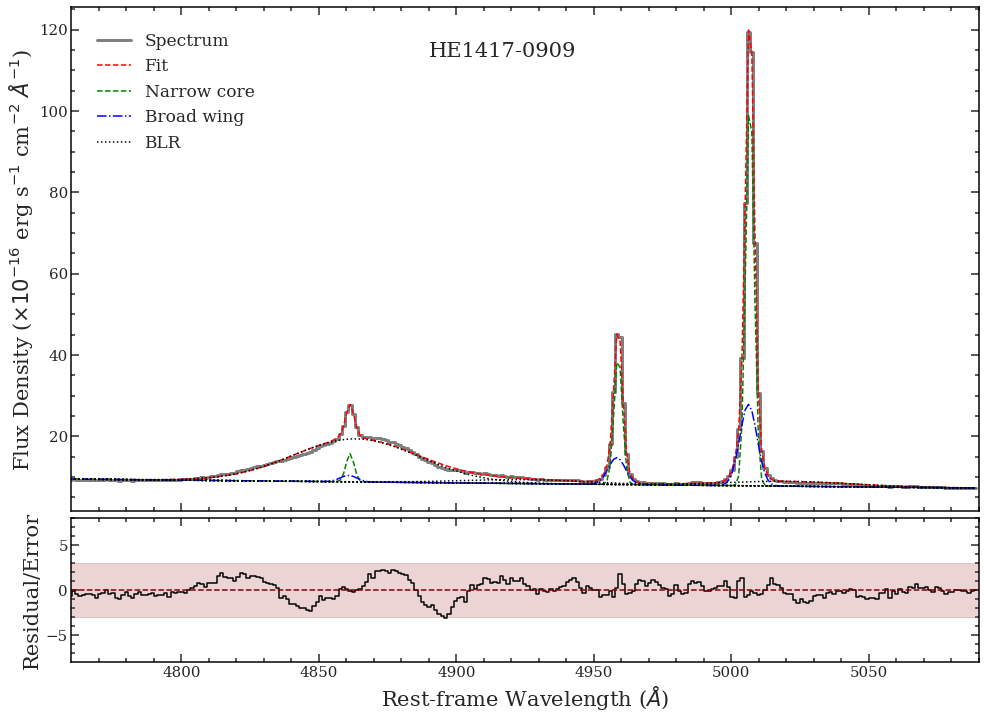

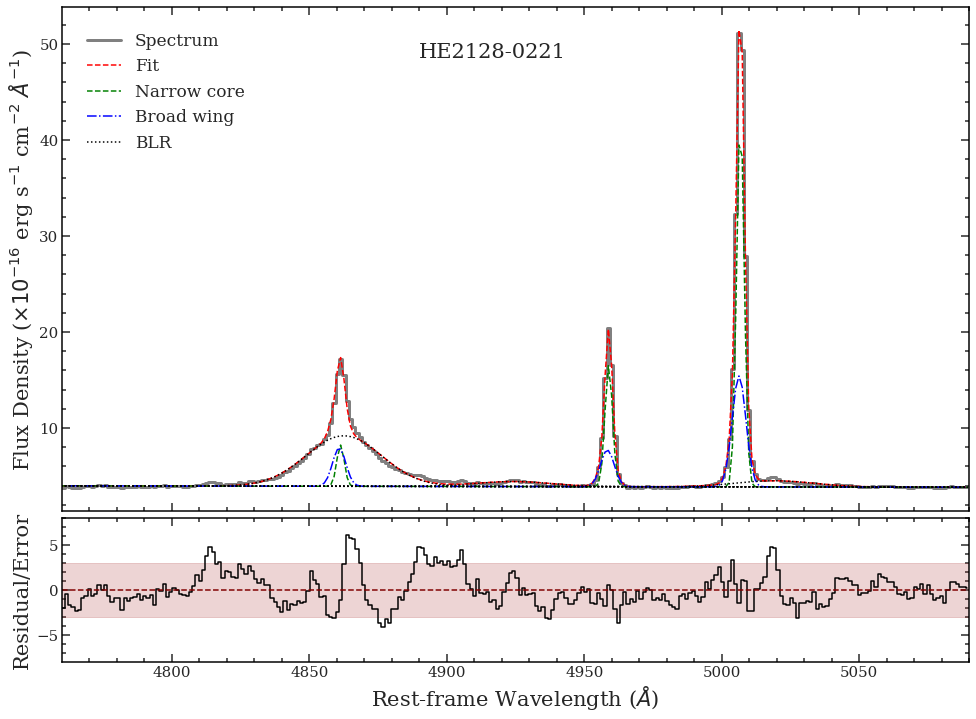

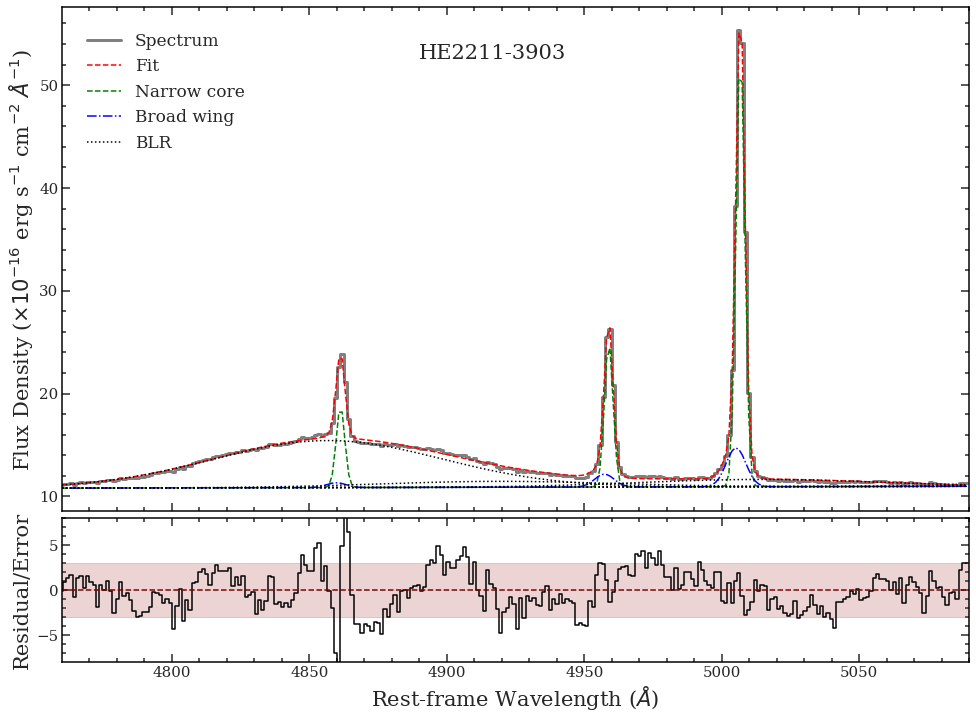

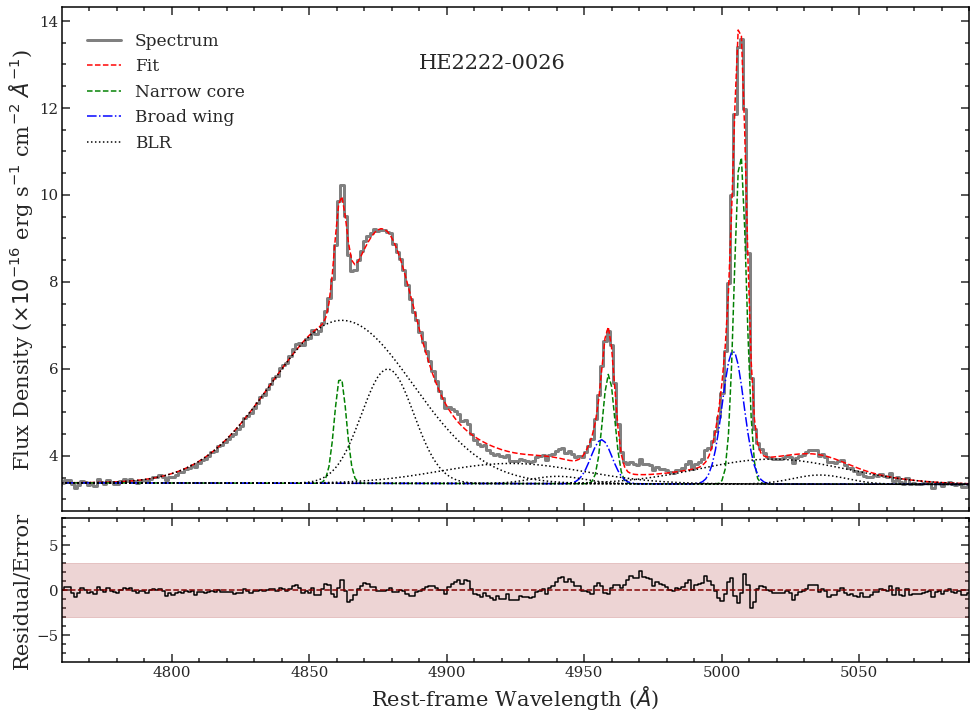

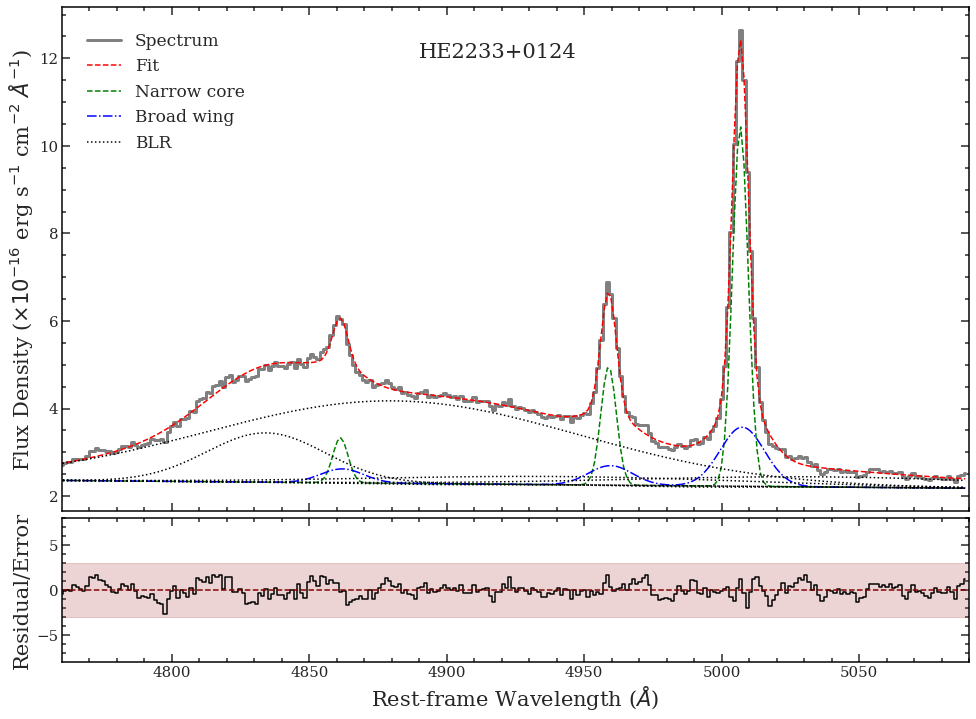

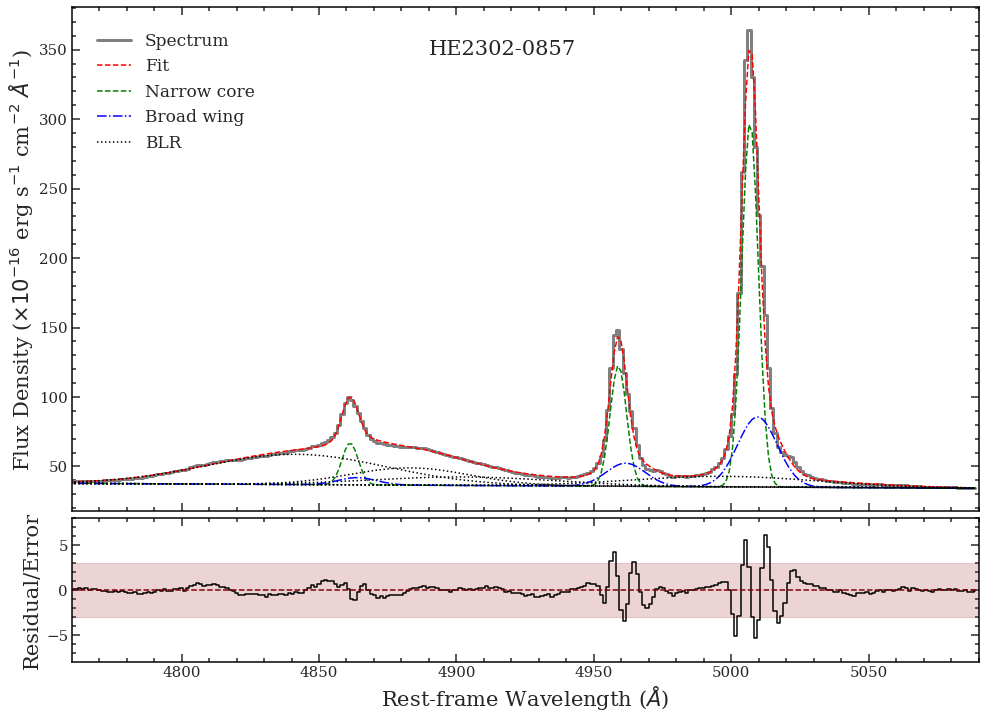

In [27]:
z = {"HE0021-1810":0.05352,"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

objs = z.keys()

broad2= {'HE0021-1810':False,'HE0021-1819':False,'HE0040-1105':False,'HE0108-4743':True,'HE0114-0015':False
        ,'HE0119-0118':True,'HE0212-0059':True,'HE0224-2834':False,'HE0227-0913':True,'HE0232-0900':False
        ,'HE0253-1641':True,'HE0345+0056':True,'HE0351+0240':True,'HE0412-0803':False,'HE0429-0247':True
        ,'HE0433-1028':True,'HE0853+0102':True,'HE0934+0119':True,'HE1011-0403':True,'HE1017-0305':False
        ,'HE1029-1831':True,'HE1107-0813':True,'HE1108-2813':False,'HE1126-0407':True,'HE1237-0504':False
        ,'HE1248-1356':False,'HE1330-1013':True,'HE1353-1917':True,'HE1417-0909':False,'HE2128-0221':False
        ,'HE2211-3903':False,'HE2222-0026':True,'HE2233+0124':True,'HE2302-0857':True}

for obj in objs:
     algorithm_script(obj,z[obj],broad2[obj]) 
